In [ ]:
!pip install pvlib
!pip install --force-reinstall --no-deps git+https://github.com/isi-ies-group/cpvlib.git

In [1]:
import pandas as pd
import pvlib
import datetime
import matplotlib.pyplot as plt
import numpy as np
from cpvlib import cpvsystem

# Parámetros de los módulos

In [2]:
mod_params_vidrio = {
    'alpha_sc': 0.0008*8.93,#temp coef of Isc 0.007144
    'a_ref': 0.712,
    'I_L_ref': 8.994,
    'I_o_ref': 0.00000157,
    'R_s': 0.01,
    'R_sh_ref': 3000,
    'EgRef': 1.121,
}

system = {   
    'surface_tilt': 30,      #Inclinación
    'surface_azimuth': 180,  #ángulo de la proyección en el suelo a la direccion norte
}

mod_params_cpv = {
    "gamma_ref": 5.524,
    "mu_gamma": 0.003,
    "I_L_ref": 0.96*0.9,
    "I_o_ref": 1.7e-10,
    "R_sh_ref": 5226,
    "R_sh_0": 21000,
    "R_sh_exp": 5.50,
    "R_s": 0.01,
    "alpha_sc": 0.00,
    "EgRef": 3.91,
    "irrad_ref": 1000,
    "temp_ref": 25,
    "cells_in_series": 12,
    "eta_m": 0.32,
    "alpha_absorption": 0.9,
    "b": 0.7,
    "iam_model": 'ashrae',
    "theta_ref": [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60],
    "iam_ref": [1.000, 1.007, 0.998, 0.991, 0.971, 0.966, 0.938, 0.894, 0.830, 0.790, 0.740, 0.649, 0.387],
}

UF_parameters_cpv = {
    "IscDNI_top": 0.96 / 1000,
    "am_thld": 4.574231933073185,
    "am_uf_m_low": 3.906372068620377e-06,
    "am_uf_m_high": -3.0335768119184845e-05,
    "ta_thld": 50,
    "ta_uf_m_low": 4.6781224141650075e-06,
    "ta_uf_m_high": 0,
    "weight_am": 0.2,
    "weight_temp": 0.8,
}

mod_params_cpv.update(UF_parameters_cpv)

# example (NO Insolight) PV module from:
# https://pvpmc.sandia.gov/PVLIB_Matlab_Help/html/pvl_calcparams_PVsyst_help.html
mod_params_flatplate = {
    "gamma_ref": 1.1,
    "mu_gamma": -0.0003,
    "I_L_ref": 8,
    "I_o_ref": 2.2e-9,
    "R_sh_ref": 200,
    "R_sh_0": 8700,
    "R_sh_exp": 5.5,
    "R_s": 0.33,
    "alpha_sc": -0.002,
    "EgRef": 1.121,
    "irrad_ref": 1000,
    "temp_ref": 25,
    "cells_in_series": 4, # 60,
    "eta_m": 0.95,  # pvsyst_celltemp() default value
    "alpha_absorption": 0.97,  # pvsyst_celltemp() default value
    "aoi_limit": 55,
}

# Funciones

In [3]:
def obtencionDatos(name, lat, lon, alt, tz):
    data_pvgis = pvlib.iotools.get_pvgis_tmy(lat, lon)
    data = data_pvgis[0].rename(columns={
        'Gb(n)': 'dni',
        'G(h)': 'ghi',
        'Gd(h)': 'dhi',
        'T2m': 'temp_air',
        'WS10m': 'wind_speed',
    })
    data = data.set_index(
        data.index.map(lambda t: t.replace(year=2010)))

    location = pvlib.location.Location(latitude=lat, 
                                       longitude=lon, 
                                       altitude=alt, 
                                       tz=tz)
    data['solar_zenith'] = pvlib.solarposition.get_solarposition(data.index, lat, lon).zenith
    data['solar_azimuth'] = pvlib.solarposition.get_solarposition(data.index, lat, lon).azimuth
    data['airmass_absolute'] = location.get_airmass(data.index).airmass_absolute
    return data

In [4]:
def generacionVidrio(params, system, data):
    dii = pvlib.irradiance.beam_component(system['surface_tilt'],
                                          system['surface_azimuth'],
                                          solar_zenith=data['solar_zenith'],
                                          solar_azimuth=data['solar_azimuth'],
                                          dni=data['dni'])

    aoi = pvlib.irradiance.aoi(system['surface_tilt'], 
                               system['surface_azimuth'],
                               solar_zenith=data['solar_zenith'],
                               solar_azimuth=data['solar_azimuth'])

    poa_sky=pvlib.irradiance.get_sky_diffuse(system['surface_tilt'],
                                             system['surface_azimuth'],
                                             solar_zenith=data['solar_zenith'],
                                             solar_azimuth=data['solar_azimuth'],
                                             ghi=data['ghi'],
                                             dhi=data['dhi'],
                                             dni=data['dni'],
                                             dni_extra=None, 
                                             airmass=None, 
                                             model='isotropic', 
                                             model_perez='allsitescomposite1990')

    poa_ground=pvlib.irradiance.get_ground_diffuse(system['surface_tilt'], 
                                                   ghi=data['ghi'], 
                                                   albedo=0.25, 
                                                   surface_type=None)

    poa_irrad=pvlib.irradiance.poa_components(aoi=aoi, 
                                              dni=data['dni'], 
                                              poa_sky_diffuse=poa_sky, 
                                              poa_ground_diffuse=poa_ground)

    effectiveIrradiance = poa_irrad.poa_direct * np.absolute(np.cos(aoi)) * pvlib.iam.ashrae(aoi) + poa_irrad.poa_diffuse

    tempcell=pvlib.temperature.pvsyst_cell(poa_irrad.poa_global, 
                                       data['temp_air'], 
                                       data['wind_speed'])

    IL, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_desoto(
        effective_irradiance=effectiveIrradiance,
        temp_cell=tempcell,
        alpha_sc=mod_params_vidrio['alpha_sc'],
        a_ref=mod_params_vidrio['a_ref'],
        I_L_ref=mod_params_vidrio['I_L_ref'],
        I_o_ref=mod_params_vidrio['I_o_ref'],
        R_sh_ref=mod_params_vidrio['R_sh_ref'],
        R_s=mod_params_vidrio['R_s'],
        EgRef=mod_params_vidrio['EgRef'],
    )

    dc_pv = pvlib.pvsystem.singlediode(
        photocurrent=IL,
        saturation_current=I0,
        resistance_series=Rs,
        resistance_shunt=Rsh,
        nNsVth=nNsVth,
        ivcurve_pnts=100,
        method='lambertw'
    )
    
    return dc_pv['p_mp']

In [5]:
def generacionCPV(paramsCPV, paramsFlatPlate, system, data):
    static_hybrid_sys = cpvsystem.StaticHybridSystem(
        surface_tilt=system['surface_tilt'],
        surface_azimuth=system['surface_azimuth'],
        module_cpv=None,
        module_flatplate=None,
        module_parameters_cpv=paramsCPV,
        module_parameters_flatplate=paramsFlatPlate,
        modules_per_string=1,
        strings_per_inverter=1,
        inverter=None,
        inverter_parameters=None,
        racking_model="insulated",
        losses_parameters=None,
        name=None,
    )

    dii_effective, poa_flatplate_static_effective = static_hybrid_sys.get_effective_irradiance(
        data['solar_zenith'],
        data['solar_azimuth'],
        #iam_param=0.7,
        #aoi_limit=55,
        dii=None,
        ghi=data['ghi'],
        dhi=data['dhi'],
        dni=data['dni']
    )


    temp_cell_35, temp_cell_flatplate = static_hybrid_sys.pvsyst_celltemp(
        dii=dii_effective,
        poa_flatplate_static=poa_flatplate_static_effective,
        temp_air=data['temp_air'],
        wind_speed=data['wind_speed']
    )

    diode_parameters_cpv, diode_parameters_flatplate = static_hybrid_sys.calcparams_pvsyst(
        dii=dii_effective,
        poa_flatplate_static=poa_flatplate_static_effective,
        temp_cell_cpv=temp_cell_35,
        temp_cell_flatplate=temp_cell_flatplate,
    )

    dc_cpv, dc_flatplate = static_hybrid_sys.singlediode(
        diode_parameters_cpv, diode_parameters_flatplate)

    uf_cpv = static_hybrid_sys.get_global_utilization_factor_cpv(data['airmass_absolute'],
                                                                 data['temp_air'])

    return dc_cpv['p_mp'] * uf_cpv + dc_flatplate['p_mp']

# Casos a analizar

In [6]:
#Se analizarán máximos y mínimos, manteniendo el resto de valores en la media.

data0 = obtencionDatos('Madrid', 40.421707, -3.612245, 695, 'utc')

#Ojo, no se si hace la media con los que son 0 tambien, por la noche, y me la baja o trastoca. Se podria eliminar esto.
#Tambien se podría contemplar el uso de los porcentajes para eliminar valores anormales.

cases = [
    ('Valores medios', data0.dni.mean(), data0.ghi.mean(), data0.dhi.mean(), data0.temp_air.mean(), data0.wind_speed.mean(), 
     data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()),  #Valores médios
    
    ('DNI_min', data0.dni.min(), data0.ghi.mean(), data0.dhi.mean(), data0.temp_air.mean(), data0.wind_speed.mean(), 
     data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()), #
    ('DNI_max', data0.dni.max(), data0.ghi.mean(), data0.dhi.mean(), data0.temp_air.mean(), data0.wind_speed.mean(), 
     data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()), #
    
    ('GHI_min', data0.dni.mean(), data0.ghi.min(), data0.dhi.mean(), data0.temp_air.mean(), data0.wind_speed.mean(), 
     data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()), #
    ('GHI_max', data0.dni.mean(), data0.ghi.max(), data0.dhi.mean(), data0.temp_air.mean(), data0.wind_speed.mean(), 
     data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()), #
    
    ('DHI_min', data0.dni.mean(), data0.ghi.mean(), data0.dhi.min(), data0.temp_air.mean(), data0.wind_speed.mean(), 
     data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()), #
    ('DHI_max', data0.dni.mean(), data0.ghi.mean(), data0.dhi.max(), data0.temp_air.mean(), data0.wind_speed.mean(), 
     data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()), #
    
    ('TempAir_min', data0.dni.mean(), data0.ghi.mean(), data0.dhi.mean(), data0.temp_air.min(), data0.wind_speed.mean(), 
     data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()), #
    ('TempAir_max', data0.dni.mean(), data0.ghi.mean(), data0.dhi.mean(), data0.temp_air.max(), data0.wind_speed.mean(), 
     data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()), #
    
    ('WindSpeed_min', data0.dni.mean(), data0.ghi.mean(), data0.dhi.mean(), data0.temp_air.mean(), data0.wind_speed.min(), 
     data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()), #
    ('WindSpeed_max', data0.dni.mean(), data0.ghi.mean(), data0.dhi.mean(), data0.temp_air.mean(), data0.wind_speed.max(), 
     data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()), #
    
    ('Zenith_min', data0.dni.mean(), data0.ghi.mean(), data0.dhi.mean(), data0.temp_air.mean(), data0.wind_speed.mean(), 
     data0.solar_zenith.min(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()), #
    ('Zenith_max', data0.dni.mean(), data0.ghi.mean(), data0.dhi.mean(), data0.temp_air.mean(), data0.wind_speed.mean(), 
     data0.solar_zenith.max(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()), #
    
    ('Azimuth_min', data0.dni.mean(), data0.ghi.mean(), data0.dhi.mean(), data0.temp_air.mean(), data0.wind_speed.mean(), 
     data0.solar_zenith.mean(), data0.solar_azimuth.min(), data0.airmass_absolute.mean()), #
    ('Azimuth_max', data0.dni.mean(), data0.ghi.mean(), data0.dhi.mean(), data0.temp_air.mean(), data0.wind_speed.mean(), 
     data0.solar_zenith.mean(), data0.solar_azimuth.max(), data0.airmass_absolute.mean()), #
    
    ('data0.airmass_min', data0.dni.mean(), data0.ghi.mean(), data0.dhi.mean(), data0.temp_air.mean(), data0.wind_speed.mean(), 
     data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.min()), #
    ('data0.airmass_max', data0.dni.mean(), data0.ghi.mean(), data0.dhi.mean(), data0.temp_air.mean(), data0.wind_speed.mean(), 
     data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.max()), #
]

conditions = pd.DataFrame(cases, columns=['Caso', 'dni', 'ghi', 'dhi', 
                                          'temp_air', 
                                          'wind_speed', 
                                          'solar_zenith', 'solar_azimuth', 
                                          'airmass_absolute'])

print(conditions.to_string(index=False))

              Caso          dni          ghi        dhi   temp_air  wind_speed  solar_zenith  solar_azimuth  airmass_absolute
    Valores medios   245.785245   205.313619   63.27109  14.331458    2.874394     89.693052     182.450606          3.674690
           DNI_min     0.000000   205.313619   63.27109  14.331458    2.874394     89.693052     182.450606          3.674690
           DNI_max  1060.470000   205.313619   63.27109  14.331458    2.874394     89.693052     182.450606          3.674690
           GHI_min   245.785245     0.000000   63.27109  14.331458    2.874394     89.693052     182.450606          3.674690
           GHI_max   245.785245  1039.000000   63.27109  14.331458    2.874394     89.693052     182.450606          3.674690
           DHI_min   245.785245   205.313619    0.00000  14.331458    2.874394     89.693052     182.450606          3.674690
           DHI_max   245.785245   205.313619  485.00000  14.331458    2.874394     89.693052     182.450606          3

In [7]:
vidrio = generacionVidrio(mod_params_vidrio, system, conditions)
CPV = generacionCPV(mod_params_cpv, mod_params_flatplate, system, conditions)

In [8]:
conditions.index = conditions['Caso']

In [9]:
conditions

,Caso,dni,ghi,dhi,temp_air,wind_speed,solar_zenith,solar_azimuth,airmass_absolute
Caso,,,,,,,,,
Valores medios,Valores medios,245.785245,205.313619,63.27109,14.331458,2.874394,89.693052,182.450606,3.674690
DNI_min,DNI_min,0.000000,205.313619,63.27109,14.331458,2.874394,89.693052,182.450606,3.674690
DNI_max,DNI_max,1060.470000,205.313619,63.27109,14.331458,2.874394,89.693052,182.450606,3.674690
GHI_min,GHI_min,245.785245,0.000000,63.27109,14.331458,2.874394,89.693052,182.450606,3.674690
GHI_max,GHI_max,245.785245,1039.000000,63.27109,14.331458,2.874394,89.693052,182.450606,3.674690
DHI_min,DHI_min,245.785245,205.313619,0.00000,14.331458,2.874394,89.693052,182.450606,3.674690
DHI_max,DHI_max,245.785245,205.313619,485.00000,14.331458,2.874394,89.693052,182.450606,3.674690
TempAir_min,TempAir_min,245.785245,205.313619,63.27109,-4.720000,2.874394,89.693052,182.450606,3.674690
TempAir_max,TempAir_max,245.785245,205.313619,63.27109,39.070000,2.874394,89.693052,182.450606,3.674690


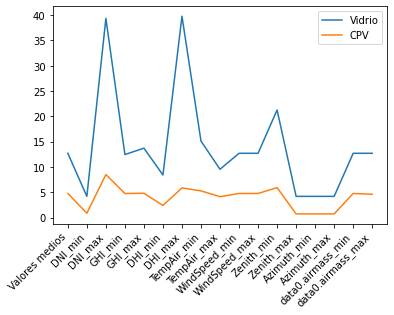

In [10]:
plt.plot(vidrio, label='Vidrio')
plt.plot(CPV, label='CPV')
plt.xticks(range(0,len(conditions.index)), conditions.index, rotation=45, horizontalalignment='right')
plt.legend()
plt.show()

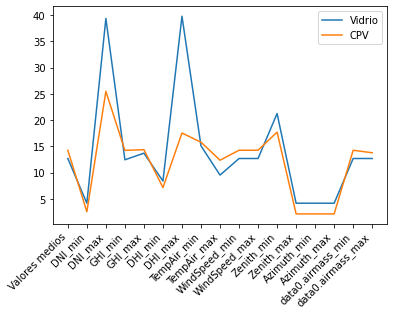

In [11]:
plt.plot(vidrio, label='Vidrio')
plt.plot(3*CPV, label='CPV')
plt.xticks(range(0,len(conditions.index)), conditions.index, rotation=45, horizontalalignment='right')
plt.legend()
plt.show()

# Análisis de DNI (irradiancia directa)

In [12]:
cases = [
    ('Valores medios', data0.dni.mean(), data0.ghi.mean(), data0.dhi.mean(), data0.temp_air.mean(), data0.wind_speed.mean(), 
     data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()),  #Valores médios
    
    ('DNI_min', data0.dni.min(), data0.ghi.mean(), data0.dhi.mean(), data0.temp_air.mean(), data0.wind_speed.mean(), 
     data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()), #
    ('DNI_max', data0.dni.max(), data0.ghi.mean(), data0.dhi.mean(), data0.temp_air.mean(), data0.wind_speed.mean(), 
     data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()), #
    
]

conditions = pd.DataFrame(cases, columns=['Caso', 'dni', 'ghi', 'dhi', 
                                          'temp_air', 
                                          'wind_speed', 
                                          'solar_zenith', 'solar_azimuth', 
                                          'airmass_absolute'])
conditions

,Caso,dni,ghi,dhi,temp_air,wind_speed,solar_zenith,solar_azimuth,airmass_absolute
0,Valores medios,245.785245,205.313619,63.27109,14.331458,2.874394,89.693052,182.450606,3.67469
1,DNI_min,0.000000,205.313619,63.27109,14.331458,2.874394,89.693052,182.450606,3.67469
2,DNI_max,1060.470000,205.313619,63.27109,14.331458,2.874394,89.693052,182.450606,3.67469


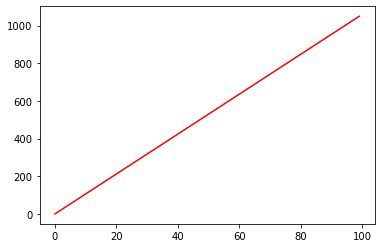

In [13]:
x=np.arange(0, 100)
plt.plot(x, 10.6047*x, 'r', label='DNI ideal')
plt.show()

In [14]:
cases = [
    ('DNI analisis', 0, data0.ghi.mean(), data0.dhi.mean(), data0.temp_air.mean(), data0.wind_speed.mean(), 
     data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()),  #Valores médios
]

DNI_analisis = pd.DataFrame(cases, columns=['Caso', 'dni', 'ghi', 'dhi', 
                                          'temp_air', 
                                          'wind_speed', 
                                          'solar_zenith', 'solar_azimuth', 
                                          'airmass_absolute'])
DNI_analisis

,Caso,dni,ghi,dhi,temp_air,wind_speed,solar_zenith,solar_azimuth,airmass_absolute
0,DNI analisis,0,205.313619,63.27109,14.331458,2.874394,89.693052,182.450606,3.67469


In [15]:
for i in range(101):
    DNI_analisis.loc[i]=['DNI analisis', 10.6047*i, data0.ghi.mean(), data0.dhi.mean(), data0.temp_air.mean(), data0.wind_speed.mean(), 
    data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()]
DNI_analisis

,Caso,dni,ghi,dhi,temp_air,wind_speed,solar_zenith,solar_azimuth,airmass_absolute
0,DNI analisis,0.0000,205.313619,63.27109,14.331458,2.874394,89.693052,182.450606,3.67469
1,DNI analisis,10.6047,205.313619,63.27109,14.331458,2.874394,89.693052,182.450606,3.67469
2,DNI analisis,21.2094,205.313619,63.27109,14.331458,2.874394,89.693052,182.450606,3.67469
3,DNI analisis,31.8141,205.313619,63.27109,14.331458,2.874394,89.693052,182.450606,3.67469
4,DNI analisis,42.4188,205.313619,63.27109,14.331458,2.874394,89.693052,182.450606,3.67469
...,...,...,...,...,...,...,...,...,...
96,DNI analisis,1018.0512,205.313619,63.27109,14.331458,2.874394,89.693052,182.450606,3.67469
97,DNI analisis,1028.6559,205.313619,63.27109,14.331458,2.874394,89.693052,182.450606,3.67469
98,DNI analisis,1039.2606,205.313619,63.27109,14.331458,2.874394,89.693052,182.450606,3.67469
99,DNI analisis,1049.8653,205.313619,63.27109,14.331458,2.874394,89.693052,182.450606,3.67469


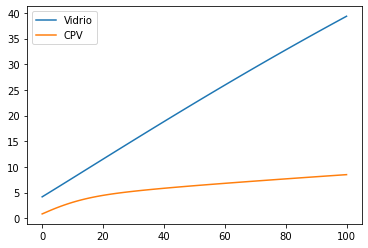

In [16]:
DNI_vidrio = generacionVidrio(mod_params_vidrio, system, DNI_analisis)
DNI_CPV = generacionCPV(mod_params_cpv, mod_params_flatplate, system, DNI_analisis)

plt.plot(DNI_vidrio, label='Vidrio')
plt.plot(DNI_CPV, label='CPV')
plt.legend()
plt.show()

# Análisis de DHI (irradiancia difusa)

In [17]:
cases = [
    ('Valores medios', data0.dni.mean(), data0.ghi.mean(), data0.dhi.mean(), data0.temp_air.mean(), data0.wind_speed.mean(), 
     data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()),  #Valores médios

    ('DHI_min', data0.dni.mean(), data0.ghi.mean(), data0.dhi.min(), data0.temp_air.mean(), data0.wind_speed.mean(), 
     data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()), #
    ('DHI_max', data0.dni.mean(), data0.ghi.mean(), data0.dhi.max(), data0.temp_air.mean(), data0.wind_speed.mean(), 
     data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()), #

]

conditions = pd.DataFrame(cases, columns=['Caso', 'dni', 'ghi', 'dhi', 
                                          'temp_air', 
                                          'wind_speed', 
                                          'solar_zenith', 'solar_azimuth', 
                                          'airmass_absolute'])
conditions 

,Caso,dni,ghi,dhi,temp_air,wind_speed,solar_zenith,solar_azimuth,airmass_absolute
0,Valores medios,245.785245,205.313619,63.27109,14.331458,2.874394,89.693052,182.450606,3.67469
1,DHI_min,245.785245,205.313619,0.00000,14.331458,2.874394,89.693052,182.450606,3.67469
2,DHI_max,245.785245,205.313619,485.00000,14.331458,2.874394,89.693052,182.450606,3.67469


In [18]:
cases = [
    ('DHI analisis', data0.dni.mean(), data0.ghi.mean(), 0, data0.temp_air.mean(), data0.wind_speed.mean(), 
     data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()),  #Valores médios
]

DHI_analisis = pd.DataFrame(cases, columns=['Caso', 'dni', 'ghi', 'dhi', 
                                          'temp_air', 
                                          'wind_speed', 
                                          'solar_zenith', 'solar_azimuth', 
                                          'airmass_absolute'])
DHI_analisis

,Caso,dni,ghi,dhi,temp_air,wind_speed,solar_zenith,solar_azimuth,airmass_absolute
0,DHI analisis,245.785245,205.313619,0,14.331458,2.874394,89.693052,182.450606,3.67469


In [19]:
for i in range(101):
    DHI_analisis.loc[i]=['DHI analisis', data0.dni.mean(), data0.ghi.mean(), 4.85*i, data0.temp_air.mean(), data0.wind_speed.mean(), 
     data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()]


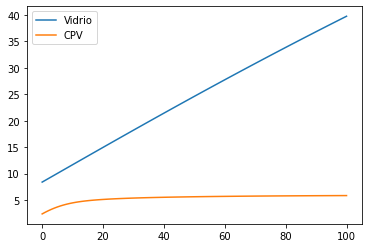

In [20]:
DHI_vidrio = generacionVidrio(mod_params_vidrio, system, DHI_analisis)
DHI_CPV = generacionCPV(mod_params_cpv, mod_params_flatplate, system, DHI_analisis)

plt.plot(DHI_vidrio, label='Vidrio')
plt.plot(DHI_CPV, label='CPV')
plt.legend()
plt.show()

# Análisis de GHI (irradiancia global)

In [21]:
cases = [
    ('Valores medios', data0.dni.mean(), data0.ghi.mean(), data0.dhi.mean(), data0.temp_air.mean(), data0.wind_speed.mean(), 
     data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()),  #Valores médios

    ('GHI_min', data0.dni.mean(), data0.ghi.min(), data0.dhi.mean(), data0.temp_air.mean(), data0.wind_speed.mean(), 
     data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()), #
    ('GHI_max', data0.dni.mean(), data0.ghi.max(), data0.dhi.mean(), data0.temp_air.mean(), data0.wind_speed.mean(), 
     data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()), #

]

conditions = pd.DataFrame(cases, columns=['Caso', 'dni', 'ghi', 'dhi', 
                                          'temp_air', 
                                          'wind_speed', 
                                          'solar_zenith', 'solar_azimuth', 
                                          'airmass_absolute'])
conditions 

,Caso,dni,ghi,dhi,temp_air,wind_speed,solar_zenith,solar_azimuth,airmass_absolute
0,Valores medios,245.785245,205.313619,63.27109,14.331458,2.874394,89.693052,182.450606,3.67469
1,GHI_min,245.785245,0.000000,63.27109,14.331458,2.874394,89.693052,182.450606,3.67469
2,GHI_max,245.785245,1039.000000,63.27109,14.331458,2.874394,89.693052,182.450606,3.67469


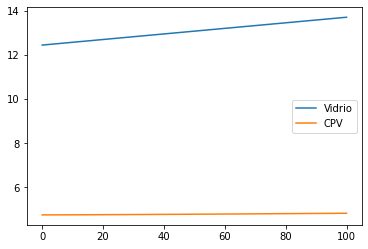

In [22]:
cases = [
    ('GHI analisis', data0.dni.mean(), 0, data0.dhi.mean(), data0.temp_air.mean(), data0.wind_speed.mean(), 
     data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()),  #Valores médios
]

GHI_analisis = pd.DataFrame(cases, columns=['Caso', 'dni', 'ghi', 'dhi', 
                                          'temp_air', 
                                          'wind_speed', 
                                          'solar_zenith', 'solar_azimuth', 
                                          'airmass_absolute'])
for i in range(101):
    GHI_analisis.loc[i]=['GHI analisis', data0.dni.mean(), 10.39*i, data0.dhi.mean(), data0.temp_air.mean(), data0.wind_speed.mean(), 
    data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()]

GHI_vidrio = generacionVidrio(mod_params_vidrio, system, GHI_analisis)
GHI_CPV = generacionCPV(mod_params_cpv, mod_params_flatplate, system, GHI_analisis)

plt.plot(GHI_vidrio, label='Vidrio')
plt.plot(GHI_CPV, label='CPV')
plt.legend()
plt.show()

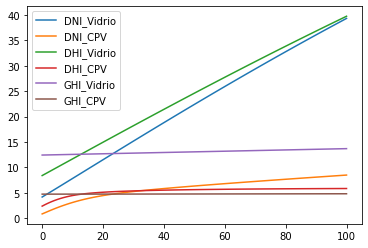

In [23]:
plt.plot(DNI_vidrio, label='DNI_Vidrio')
plt.plot(DNI_CPV, label='DNI_CPV')
plt.plot(DHI_vidrio, label='DHI_Vidrio')
plt.plot(DHI_CPV, label='DHI_CPV')
plt.plot(GHI_vidrio, label='GHI_Vidrio')
plt.plot(GHI_CPV, label='GHI_CPV')
plt.legend()
plt.show()

# Análisis de la temperatura del aire

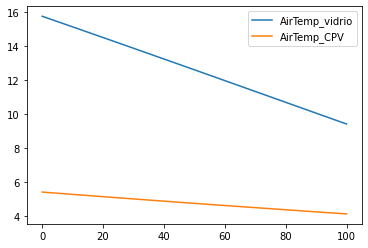

In [24]:
cases = [
    ('Airtemp analisis', data0.dni.mean(), data0.ghi.mean(), data0.dhi.mean(), -10, data0.wind_speed.mean(), 
     data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()),  #Valores médios
]

AirTemp_analisis = pd.DataFrame(cases, columns=['Caso', 'dni', 'ghi', 'dhi', 
                                          'temp_air', 
                                          'wind_speed', 
                                          'solar_zenith', 'solar_azimuth', 
                                          'airmass_absolute'])
for i in range(101):
    AirTemp_analisis.loc[i]=['Airtemp analisis', data0.dni.mean(), data0.ghi.mean(), data0.dhi.mean(), 0.5*i-10, data0.wind_speed.mean(), 
    data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()]

AirTemp_vidrio = generacionVidrio(mod_params_vidrio, system, AirTemp_analisis)
AirTemp_CPV = generacionCPV(mod_params_cpv, mod_params_flatplate, system, AirTemp_analisis)

plt.plot(AirTemp_vidrio, label='AirTemp_vidrio')
plt.plot(AirTemp_CPV , label='AirTemp_CPV')
plt.legend()
plt.show()

# Análisis de la transparencia

In [25]:
cases = [
    ('Airtemp analisis', data0.dni.mean(), data0.ghi.mean(), data0.dhi.mean(), data0.temp_air.mean(), data0.wind_speed.mean(), 
     data0.solar_zenith.mean(), data0.solar_azimuth.mean(), data0.airmass_absolute.mean()),  #Valores médios
]

Valores_medios = pd.DataFrame(cases, columns=['Caso', 'dni', 'ghi', 'dhi', 
                                          'temp_air', 
                                          'wind_speed', 
                                          'solar_zenith', 'solar_azimuth', 
                                          'airmass_absolute'])

In [26]:
Valores_medios

,Caso,dni,ghi,dhi,temp_air,wind_speed,solar_zenith,solar_azimuth,airmass_absolute
0,Airtemp analisis,245.785245,205.313619,63.27109,14.331458,2.874394,89.693052,182.450606,3.67469


In [27]:

for i in range(100):
    Transparencia_vidrio = generacionVidrio(mod_params_vidrio, system, Valores_medios)*48/(x+1)


In [28]:
Transparencia_vidrio

array([609.1721897 , 304.58609485, 203.05739657, 152.29304743,
       121.83443794, 101.52869828,  87.02459853,  76.14652371,
        67.68579886,  60.91721897,  55.37928997,  50.76434914,
        46.85939921,  43.51229926,  40.61147931,  38.07326186,
        35.83365822,  33.84289943,  32.06169419,  30.45860949,
        29.00819951,  27.68964499,  26.48574738,  25.38217457,
        24.36688759,  23.4296996 ,  22.56193295,  21.75614963,
        21.00593758,  20.30573966,  19.6507158 ,  19.03663093,
        18.45976332,  17.91682911,  17.40491971,  16.92144971,
        16.46411324,  16.0308471 ,  15.61979974,  15.22930474,
        14.85785829,  14.50409975,  14.16679511,  13.84482249,
        13.53715977,  13.24287369,  12.96111042,  12.69108729,
        12.4320855 ,  12.18344379,  11.94455274,  11.7148498 ,
        11.4938149 ,  11.28096648,  11.07585799,  10.87807482,
        10.6872314 ,  10.50296879,  10.32495237,  10.15286983,
         9.98642934,   9.8253579 ,   9.66939984,   9.51

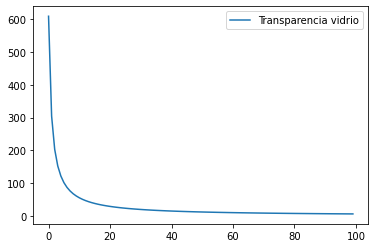

In [29]:
plt.plot(Transparencia_vidrio, label='Transparencia vidrio')
plt.legend()
plt.show()

In [30]:
generacionVidrio(mod_params_vidrio, system, Valores_medios)

array([12.69108729])